In [356]:
%matplotlib inline
import matplotlib
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
import plotly.plotly as py
from scipy.stats import gaussian_kde
import operator
import pylab
import pandas as pd
from html import HTML
from itertools import groupby
from operator import itemgetter
import itertools

In [357]:
admit_file = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/all_icu_tracking/icuadmit.csv"
collection_file = "/Users/elizabethwebster/Desktop/daily_cdiff_reporting/all_icu_tracking/collection.csv"

In [358]:
def convert_to_python_dates (our_date, delim):
    year,month,day = map(int, our_date.split(delim))
    if year < 1000:
        year+=2000 # corrects for the year been just two digits
    return datetime.date(year, month, day)


In [359]:
def consecutive(a, b):
    return abs((a - b).days) == 1

In [363]:
def set_up_dict(admit_file):
    '''
    Returns:
    sample_dict = key =(person,admit_date,room) -> {}
    '''
    with open(admit_file) as f:
        headerline = f.readline()
        temp_dict={} # key=(patient_id, room) -> list of dates patient in room
        s_dict={} # 
        for l in f:
            ll = l.strip().split(",")
            pid,tmp,room,tmp2 = ll[0:4]
            report_date = convert_to_python_dates(tmp2,"-")
            temp_dict.setdefault((pid,room), set()).add(convert_to_python_dates(tmp2,"-"))
        for key in temp_dict:
            sdates = sorted(temp_dict[key])
            if len(sdates) == 1: #person only in ICU for a day
                s_dict[key[0],sdates[0],key[1]]={}
            elif all(consecutive(sdates[i], sdates[i+1]) for i in xrange(len(sdates)-1)):
                admit_date = min(sdates)
                s_dict[key[0],admit_date,key[1]]={}
            else: # non-consecutive dates
                for i in xrange(len(sdates)):
                    if sdates[i] - sdates[i-1] > datetime.timedelta(1):
                        if len(sdates[0:i-1]) > 0:
                            admit_date = min(sdates[0:i-1])
                            s_dict[key[0],admit_date,key[1]]={}
                            s_dict[key[0],sdates[i],key[1]]={}
        return s_dict                        

In [364]:
sample_dict_empty = set_up_dict(admit_file)

In [365]:
print sample_dict_empty

{('179990', datetime.date(2015, 12, 22), 'SICU'): {}, ('179296', datetime.date(2015, 12, 8), 'NSIC'): {}, ('179197', datetime.date(2015, 12, 12), 'CSIU'): {}, ('180051', datetime.date(2015, 12, 23), 'NSIC'): {}, ('180451', datetime.date(2016, 1, 6), 'CSIU'): {}, ('168103', datetime.date(2015, 10, 6), 'MICU'): {}, ('163732', datetime.date(2015, 8, 21), 'NICU'): {}, ('181386', datetime.date(2016, 1, 13), 'NSIC'): {}, ('170541', datetime.date(2015, 11, 20), 'CSIU'): {}, ('168854', datetime.date(2015, 9, 11), 'PICU'): {}, ('178453', datetime.date(2015, 11, 20), 'PICU'): {}, ('179291', datetime.date(2015, 12, 8), 'CCU'): {}, ('179723', datetime.date(2015, 12, 16), 'CCU'): {}, ('180126', datetime.date(2015, 12, 28), 'CCU'): {}, ('179600', datetime.date(2015, 12, 14), 'SICU'): {}, ('178529', datetime.date(2015, 11, 23), 'CSIU'): {}, ('178616', datetime.date(2015, 11, 24), 'NSIC'): {}, ('163638', datetime.date(2015, 12, 25), 'NSIC'): {}, ('180120', datetime.date(2015, 12, 27), 'NSIC'): {}, ('1

In [181]:
def get_sampling_dates(col_file):
    '''
    Adds in the sample collection information to give the following dictionary:
    s_dict[(person,room)] = [(sample_date1,stool),(sample_date2,swab)...(sample_daten,stool)]

    '''
    s_dict={}
    with open(col_file) as f:
        headerline = f.readline()
        for l in f:
            ll = l.strip().split(",")
            pid,icu,collection_date,tmp2,sample_type = ll[0:6]
            if tmp2 == "NULL":
                sampling_date = convert_to_python_dates(collection_date,"-") #Use collection date instead  
                b = sampling_date,sample_type
            else:
                sampling_date = convert_to_python_dates(tmp2,"-") #Use actual sampling date
                b = sampling_date,sample_type
            s_dict.setdefault((pid,icu), set()).add(b)
    return s_dict

In [182]:
sampling_dates = get_sampling_dates(collection_file)

In [183]:
def date_cutoff(sample_dict_empty,cutoffs):
    '''
    cutoffs is a dictionary keyed on icu with values of the start dates
    ex. 
    Returns dirctionary to only include individuals that were admitted to an ICU on or after a certain date
    '''
    new_dict = {}
    for key in sample_dict_empty:
            if key[2] in cutoffs:
                start = cutoffs[key[2]]
                if key[1] >= start:
                    new_dict[key[0],key[1],key[2]] = {}
    return new_dict     

In [184]:
cutoff_dates = {'SICU': datetime.date(2015,9,14), 'MICU': datetime.date(2015,12,1), 'NSIC': datetime.date(2015,11,17)}

In [185]:
new_empty_dict = date_cutoff(sample_dict_empty,cutoff_dates)

In [355]:
print new_empty_dict

{('179990', datetime.date(2015, 12, 22), 'SICU'): {}, ('179296', datetime.date(2015, 12, 8), 'NSIC'): {}, ('140760', datetime.date(2015, 11, 20), 'SICU'): {}, ('178520', datetime.date(2015, 11, 21), 'NSIC'): {}, ('178573', datetime.date(2015, 12, 16), 'SICU'): {}, ('179920', datetime.date(2015, 12, 21), 'NSIC'): {}, ('180051', datetime.date(2015, 12, 23), 'NSIC'): {}, ('147032', datetime.date(2015, 12, 1), 'SICU'): {}, ('150538', datetime.date(2015, 10, 7), 'SICU'): {}, ('181386', datetime.date(2016, 1, 13), 'NSIC'): {}, ('178343', datetime.date(2016, 1, 11), 'MICU'): {}, ('179812', datetime.date(2015, 12, 18), 'SICU'): {}, ('169236', datetime.date(2015, 11, 22), 'SICU'): {}, ('180208', datetime.date(2015, 12, 31), 'NSIC'): {}, ('77045', datetime.date(2015, 10, 13), 'SICU'): {}, ('28319', datetime.date(2015, 10, 13), 'SICU'): {}, ('179600', datetime.date(2015, 12, 14), 'SICU'): {}, ('178616', datetime.date(2015, 11, 24), 'NSIC'): {}, ('166294', datetime.date(2015, 10, 4), 'SICU'): {}, 

In [200]:
def make_full_dict(sampling_dates,sample_dict_empty):
    '''
    Concatenate the two dictionaries and make a full dictionary with all of the info
    sample_dict_full[(person,room,admit_date)] = [(sample_date1,stool),(sample_date2,swab)...(sample_daten,stool)]
    '''
    final_dict = {}
    for key in sampling_dates:
        visits = [entry for entry in new_empty_dict if key[0] == entry[0] and key[1] == entry [2]]
        if len(visits) > 1:
            visits = sorted(visits)
            nvis = len(visits)
            for i in xrange(nvis-1):
                for date in sampling_dates[key]:
                    if date[0] > visits[i][1] and date[0] < visits[i+1][1]:
                        final_dict.setdefault((visits[i][0],visits[i][1],visits[i][2]),set()).add(date)
        else: #one visit
            for item in visits:
                final_dict[item]=sampling_dates[key]
    #Get non sampled
    for key in sample_dict_empty:
        if key not in final_dict:
            if (key[0],key[2]) in sampling_dates:
                final_dict[key] = sampling_dates[key[0],key[2]]
            else: final_dict[key]="0" #meaning non sampled
    return final_dict

In [201]:
sample_dict_full = make_full_dict(sampling_dates,new_empty_dict)

In [ ]:
def get_mean_length_between_samples(collectionDates):

In [ ]:
def fraction_patients_collected(collectionDates,addtoICUdates, op):

In [ ]:
def number_samples_collected(collectionDates,addtoICUdates, op):

In [ ]:
def get_agg_stats(addToICUDates, collectionDates, ICU):

In [ ]:
def list_missing(addToICUDates, collectionDates):

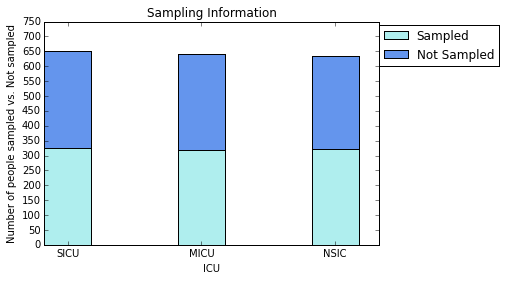

In [350]:
sampled = {}
not_sampled = {}
s = 0
ns = 0
icus_of_interest = ['SICU','MICU','NSIC']
for key in sample_dict_full:
    if key[2] in icus_of_interest:
        if sample_dict_full[key] != '0' and  sample_dict_full[key] != "NULL":
            sampled[key[2]]= s
            s = s+1
        else:
            not_sampled[key[2]]= s
            ns = ns+1
        
   
N=len(icus_of_interest)
ind = np.arange(N)  
width = 0.35
p1 = plt.bar(ind,sampled.values(), width, color='paleturquoise')
p2 = plt.bar(ind, not_sampled.values(), width, color='cornflowerblue',bottom=sampled.values())
plt.ylabel('Number of people sampled vs. Not sampled')
plt.xlabel("ICU")
plt.title('Sampling Information')
plt.xticks(ind + width/2., icus_of_interest)
plt.yticks(np.arange(0, 800, 50))
plt.legend((p1[0], p2[0]), ('Sampled', 'Not Sampled'),loc=(1.0,0.8))
plt.savefig("sampling_dat.png", bbox_inches='tight')
plt.show()
plt.close() 


In [351]:
print sampled
print not_sampled

{'SICU': 325, 'NSIC': 319, 'MICU': 321}
{'SICU': 326, 'NSIC': 321, 'MICU': 314}


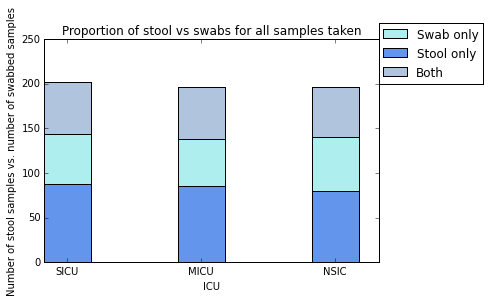

In [345]:
swab_only = {}
stool_only = {}
both = {}
so = 0
sto = 0
b = 0

icus_of_interest = ['SICU','MICU','NSIC']
for key in sample_dict_full:
    if key[2] in icus_of_interest:
        tupitem = list(sample_dict_full[key])
        item = list(itertools.chain(*tupitem))
        if 'Stools' and not 'Swabs' in item and not 'NULL' in item and not '0' in item:
            sto = sto + 1
            stool_only[key[2]] = sto
        elif 'Swabs' and not 'Stools' in item and not 'NULL' in item and not '0' in item:
            so = so + 1
            swab_only[key[2]] = so
                
        elif 'Swabs' and 'Stools' in item and not 'NULL' in item and not '0' in item:
            b = b + 1
            both[key[2]] = b

N=len(icus_of_interest)
ind = np.arange(N)  
width = 0.35
p1 = plt.bar(ind,swab_only.values(), width, color='paleturquoise')
p2 = plt.bar(ind,stool_only.values(), width, color='cornflowerblue')
p3 = plt.bar(ind,both.values(), width, color='lightsteelblue',bottom=swab_only.values())

plt.ylabel('Number of stool samples vs. number of swabbed samples')
plt.xlabel("ICU")
plt.title('Proportion of stool vs swabs for all samples taken')
plt.xticks(ind + width/2., icus_of_interest)
plt.yticks(np.arange(0, 300, 50))
plt.legend((p1[0], p2[0],p3[0]), ('Swab only','Stool only','Both'),loc=(1.0,0.8))
plt.savefig("stool_vs_swabbed.png", bbox_inches='tight')
plt.show()
plt.close() 
            

In [353]:
print swab_only 
print stool_only
print both 

print sampled


{'SICU': 143, 'NSIC': 138, 'MICU': 140}
{'SICU': 87, 'NSIC': 85, 'MICU': 80}
{'SICU': 59, 'NSIC': 58, 'MICU': 56}
{'SICU': 325, 'NSIC': 319, 'MICU': 321}


{('179990', datetime.date(2015, 12, 22), 'SICU'): set([(datetime.date(2015, 12, 22), 'Swabs')]), ('179296', datetime.date(2015, 12, 8), 'NSIC'): '0', ('140760', datetime.date(2015, 11, 20), 'SICU'): set([(datetime.date(2015, 11, 19), 'Swabs')]), ('179424', datetime.date(2015, 12, 10), 'NSIC'): '0', ('178573', datetime.date(2015, 12, 16), 'SICU'): set([(datetime.date(2015, 12, 15), 'Swabs')]), ('179920', datetime.date(2015, 12, 21), 'NSIC'): '0', ('180051', datetime.date(2015, 12, 23), 'NSIC'): '0', ('147032', datetime.date(2015, 12, 1), 'SICU'): set([(datetime.date(2015, 11, 30), 'Swabs')]), ('150538', datetime.date(2015, 10, 7), 'SICU'): set([(datetime.date(2015, 9, 14), 'Stools'), (datetime.date(2015, 10, 9), 'Stools'), (datetime.date(2015, 10, 7), 'Stools')]), ('181386', datetime.date(2016, 1, 13), 'NSIC'): '0', ('178343', datetime.date(2016, 1, 11), 'MICU'): set([(datetime.date(2016, 1, 11), 'NULL')]), ('144964', datetime.date(2015, 12, 5), 'MICU'): set([(datetime.date(2016, 1, 2),

In [ ]:
def get_patients_sampled_within_x_days (sample_dict_full):
    '''
   point in the graph for every day in the week and then sample in a window around
each day. highlight what days correspond to weekends to see how we're doing with those collections.
    '''
    end_date = datetime.date.today()
    daterange = (end_date-start_date).days # days between first and last date
    date_bins = map(lambda x: datetime.timedelta(x)+start_date, range(x,daterange,x)) # dates that we are checking
    total_patients   = []
    sampled_patients = []
    for bin_end_date in date_bins:
        # first find how many total patients there were
        # and save MRNS
        bin_start_date = bin_end_date-datetime.timedelta(x)
        mrnsInDate = set()
        for mrn, mrnDates in adDates.items():
            # check and see if this person was admitted
            admitDate, exitDate = min(mrnDates), max(mrnDates)
            if all_flag:
                if admitDate <= bin_end_date and exitDate >= bin_start_date:
                    mrnsInDate.add(mrn)    
            elif admitDate <= bin_start_date and exitDate >= bin_end_date:
                mrnsInDate.add(mrn)
        mrnsCollected = set()
        for mrn in mrnsInDate:
            if mrn in coDates:
                mrnCoDates = coDates[mrn]
                # CHANGE THIS TO A BINARY SEARCH!!!!
                for codate in mrnCoDates:
                    if codate >= bin_start_date and codate <= bin_end_date: # check to see if there is a sample within that time
                        mrnsCollected.add(mrn)
                        break
        total_patients.append(len(mrnsInDate))
        sampled_patients.append(len(mrnsCollected))
    return total_patients, sampled_patients, date_bins

   (Admit date >= bin start date  &&  Admit date <= bin end date)
OR (Exit date  >= bin start date  &&  Exit date  <= bin end date)
OR (Admit date <= bin start date  &&  Exit date  >= bin end date)
